In [1]:
import pandas as pd
import numpy as np
import requests
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import xmltodict
import pprint
import geocoder
import folium
import seaborn as sns

DD_file = 'C:\\users\\student\\mypy\\data\\DD\\Drunk_Driving_2020.csv'
f = pd.read_csv(DD_file, encoding='euc-kr')
f.head()

,연번,성별,적발횟수,나이,알콜농도,측정일시,관할경찰서
0,1,남자,1,30,0.105,2020-01-01 0:03,일산동부경찰서
1,2,남자,1,57,0.077,2020-01-01 0:13,부산연제경찰서
2,3,남자,1,68,0.089,2020-01-01 0:17,부천소사경찰서
3,4,남자,1,39,0.133,2020-01-01 0:17,마산중부경찰서
4,5,남자,1,37,측정거부,2020-01-01 0:19,수원서부경찰서


In [2]:
df = pd.DataFrame(f)
df = df.set_index('연번')

In [3]:
df.head()

,성별,적발횟수,나이,알콜농도,측정일시,관할경찰서
연번,,,,,,
1,남자,1,30,0.105,2020-01-01 0:03,일산동부경찰서
2,남자,1,57,0.077,2020-01-01 0:13,부산연제경찰서
3,남자,1,68,0.089,2020-01-01 0:17,부천소사경찰서
4,남자,1,39,0.133,2020-01-01 0:17,마산중부경찰서
5,남자,1,37,측정거부,2020-01-01 0:19,수원서부경찰서


In [4]:
df_age_den = df[['나이','알콜농도']]
df_age_den

,나이,알콜농도
연번,,
1,30,0.105
2,57,0.077
3,68,0.089
4,39,0.133
5,37,측정거부
...,...,...
24798,25,0.097
24799,47,0.175
24800,48,0.122


In [5]:
age_count = sum(df_age_den['나이'] == '불명')
den_count = sum(df_age_den['알콜농도'] == '측정거부')
age_sum = len(df_age_den['나이'])
den_sum = len(df_age_den['알콜농도'])

print('나이 불명 비율:', age_count/age_sum, '\n', '알콜농도 측정거부 비율:',
      den_count/den_sum)

나이 불명 비율: 0.000524151278122732 
 알콜농도 측정거부 비율: 0.04044028707362309


In [6]:
#매우 낮은 비율이므로 해당 행 제거
df_age_den = df_age_den.drop(df_age_den[df_age_den['알콜농도'] == '측정거부'].index)
df_age_den = df_age_den.drop(df_age_den[df_age_den['나이'] == '불명'].index)

In [7]:
#object dtype을 int와 float으로 수정
df_age_den['나이'] = df_age_den['나이'].astype('int64')
df_age_den['알콜농도'] = df_age_den['알콜농도'].astype('float')

In [8]:
df_age_den.describe()

#이상치 중 -60 넘는 값이 보임

,나이,알콜농도
count,23790.000000,23790.000000
mean,41.502648,0.111889
std,12.573084,0.050534
min,-67.000000,0.030000
25%,31.000000,0.075000
50%,41.000000,0.107000
75%,51.000000,0.142000
max,92.000000,0.980000


In [9]:
#오타로 추정 마이너스 제거해줌

df_age_den['나이'] = df_age_den['나이'].apply(lambda x: -x if x < 0 else x)

In [10]:
df_age_den.describe()

,나이,알콜농도
count,23790.000000,23790.000000
mean,41.508281,0.111889
std,12.554476,0.050534
min,14.000000,0.030000
25%,31.000000,0.075000
50%,41.000000,0.107000
75%,51.000000,0.142000
max,92.000000,0.980000


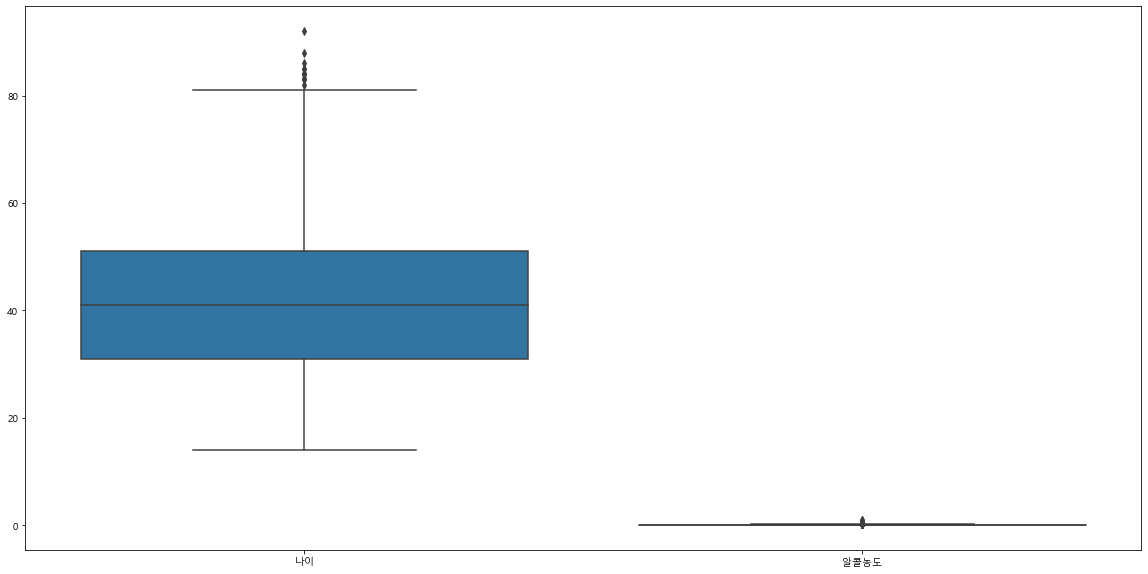

In [11]:
#각각을 boxplot 그려보기
%matplotlib inline
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False
#font 설정
plt.figure(figsize=(20,10))
#크기 설정

sns.boxplot(data = df_age_den)
plt.show()

#그리고 나이와 알콜농도 스케일이 달라 찌그러져 보임

In [12]:
print('나이 최소:',min(df_age_den['나이']),'최대:',max(df_age_den['나이']))
print('농도 최소:',min(df_age_den['알콜농도']),'최대:',max(df_age_den['알콜농도']))

#scale 차이가 남

나이 최소: 14 최대: 92
농도 최소: 0.03 최대: 0.98


In [13]:
df_scaled = pd.DataFrame()
df_scaled['나이'] = ((df_age_den['나이']) - min(df_age_den['나이']))/(max(df_age_den['나이']) - min(df_age_den['나이']))
df_scaled['알콜농도'] = ((df_age_den['알콜농도']) - min(df_age_den['알콜농도']))/(max(df_age_den['알콜농도']) - min(df_age_den['알콜농도']))
# 나이 - 최소 나이 = 나이 값이 0부터 존재하도록 함, 값의 범위는 0 ~ 최대 나이 - 최소 나이
# 이를 최대 나이 - 최소 나이 해주면 0 ~ 1 사이 값이 됨
# 알콜농도도 마찬가지

In [14]:
print('나이 최소:',min(df_scaled['나이']),'최대:',max(df_scaled['나이']))
print('농도 최소:',min(df_scaled['알콜농도']),'최대:',max(df_scaled['알콜농도']))

나이 최소: 0.0 최대: 1.0
농도 최소: 0.0 최대: 1.0


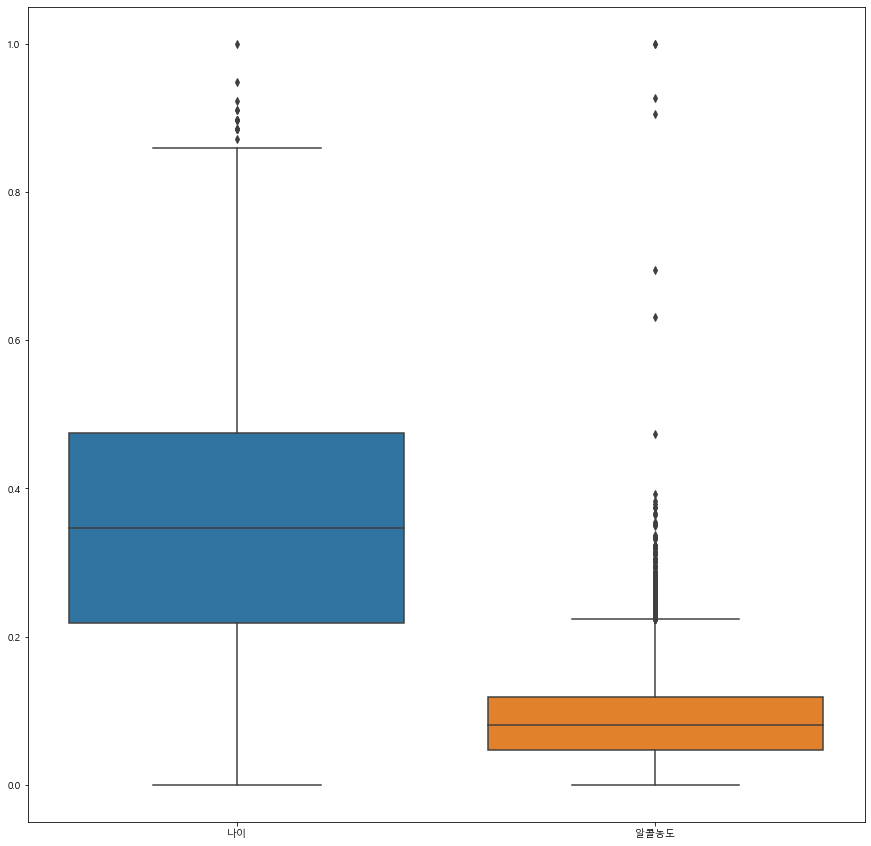

In [15]:
plt.figure(figsize=(15,15))
sns.boxplot(data = df_scaled)
plt.show()

# 혈중 알콜 농도 참고 자료: https://www.donga.com/news/Society/article/all/20170809/85750027/2

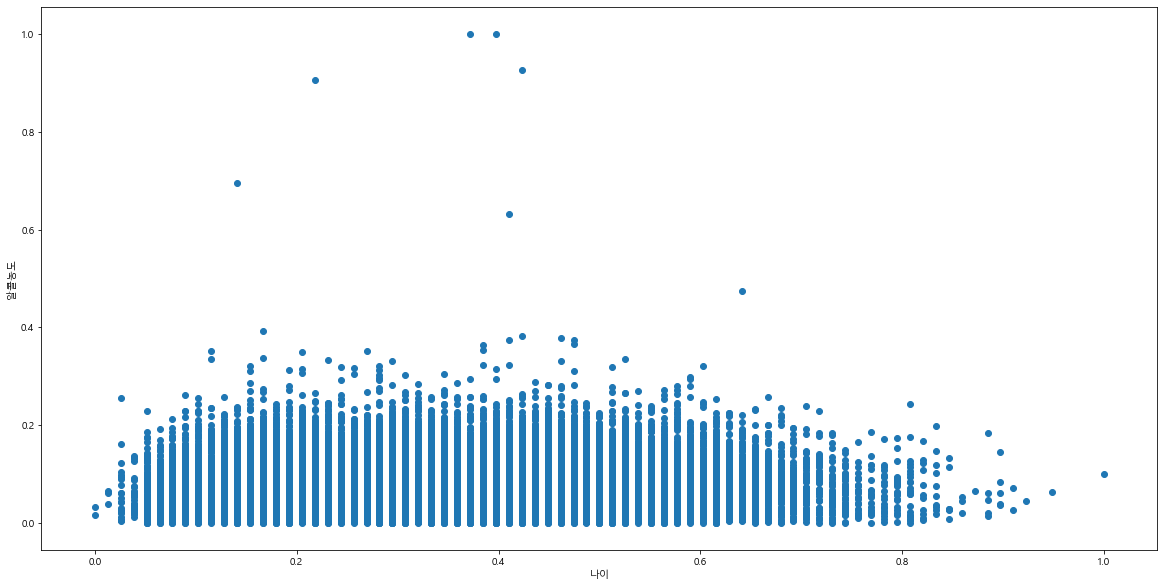

In [16]:
plt.figure(figsize=(20,10))
x = df_scaled['나이']
y = df_scaled['알콜농도']

plt.xlabel('나이')
plt.ylabel('알콜농도')

plt.scatter(x,y)
plt.show()

In [17]:
df_scaled['나이'].corr(df_scaled['알콜농도'])
#0에 아주 가까움: 두 데이터는 독립이라는 의미

-0.013466233833952264